<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Using_Pytorch_to_fight_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pytorch to Fight Cancer

## Training an image classifier

We will do the following steps in order:

1. Load and normalize the dataset training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

First, we check if GPU is connected. The `nvidia-smi` command (NVIDIA System Management Interface) is used to monitor and manage NVIDIA GPUs (Graphics Processing Units) in a system. It provides detailed information about the status and performance of the GPUs, including GPU utilization, temperature, memory usage, processes utilizing the GPU, and more.

[`nvidia-smi`](https://www.baeldung.com/linux/nvidia-smi-full-gpu-details) is a useful tool for monitoring and diagnosing the performance of NVIDIA GPUs in a system.

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Setting: `/content` and `/content/datasets`

We save the root directory of the project '/content' as 'HOME' since we will be navigating through the directory to have multiple projects under the same HOME. Additionally, we will have the datasets in the 'dataset' directory, so all datasets are easily accessible for any project.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


Next, it imports the drive module from the google.colab library, which provides functionalities for mounting Google Drive in Google Colab.

Additionally, Google Drive is mounted in Google Colab and made available at the path /content/drive. The user will be prompted to authorize access to Google Drive. Once authorized, the content of Google Drive will be accessible from that point onwards in the Colab notebook.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. LOAD DATASET and DISPLAY.

Create the dataset directory (if it doesn't exist), where we are going to save the dataset with which we are going to train our CNN.

In [4]:
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content


In [5]:
# Change to new datsets folder
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
!wget -q https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
!unzip -qq -o exp0.zip

dataset_dir = /content/datasets


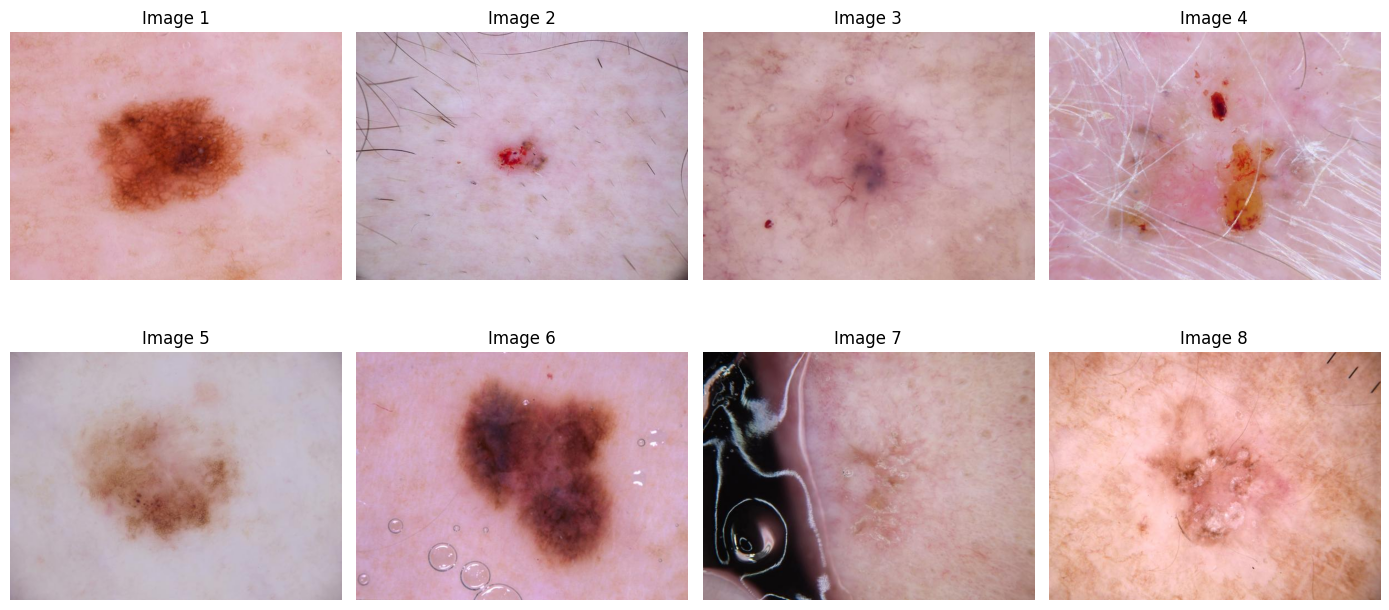

In [6]:
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Directory of the images
image_directory = f'/content/datasets/exp0/test/class_1/'

# List of image paths
image_paths = glob.glob(image_directory + '*.jpg')[:8]

# Set up the figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Iterate through the images and display them in the subplots
for i, image_path in enumerate(image_paths):
    row = i // 4
    col = i % 4
    img = mpimg.imread(image_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Image {i + 1}')
    axs[row, col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()

In [7]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm # progress bar

In machine learning, it is common to divide the dataset into three main parts: training set, validation set and test set. Here I explain each of them:

- Train Set: This dataset is used to train the model. That is, the model learns from this data by adjusting its parameters to minimise the loss function. The model is iteratively fitted to this data set during training, using optimisation techniques such as gradient descent. Generally, the training set is the largest, as an adequate amount of data is required for the model to learn meaningful patterns.
- Validation Set: After training the model with the training set, the validation set is used to adjust the hyperparameters of the model and evaluate its performance. The validation set is used to select the best model among several possible configurations, avoiding overfitting to the test set. This dataset is used to adjust the model architecture, learning rate or other hyperparameters, in order to obtain a generalisable model.
- Test Set: This data set is used to evaluate the final performance of the model after it has been trained and validated. The test set is essentially a stand-alone data set that the model has not seen during training or validation. It provides an objective estimate of the model's performance on unseen data and helps assess its ability to generalise to new samples.

In [8]:
#train, validation and test data directory

train_dir = "/content/datasets/exp0/train/"
val_dir   = "/content/datasets/exp0/val/"
test_dir  = "/content/datasets/exp0/test/"


# Definir transformación para calcular la media y la desviación estándar
transform = transforms.Compose([
    transforms.ToTensor()  # Convierte las imágenes a tensores
])

# Cargar el conjunto de datos ImageFolder y aplicar la transformación
dataset = datasets.ImageFolder(root= train_dir, transform=transform)

# Calcular la media y la desviación estándar
loader = DataLoader(dataset, batch_size=1, shuffle=False)

mean_sum = 0.0
std_sum = 0.0
total_samples = 0

for images, _ in loader:
    mean_sum += torch.mean(images, dim=[0, 2, 3])
    std_sum += torch.std(images, dim=[0, 2, 3])
    total_samples += 1

mean = mean_sum / total_samples
std = std_sum / total_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.7513, 0.5535, 0.5788])
Std: tensor([0.0921, 0.1196, 0.1349])


In [10]:
#train, validation and test data directory

train_dir = "/content/datasets/exp0/train/"
val_dir   = "/content/datasets/exp0/val/"
test_dir  = "/content/datasets/exp0/test/"

train_set = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

val_set = datasets.ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

test_set = datasets.ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

print(f"Length of Train Data :{len(train_set)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")

classes = train_set.classes
print('Classes: ', classes)



Length of Train Data :2700
Length of Validation Data : 300
Length of Test Data : 600
Classes:  ['class_0', 'class_1']


Let us show one example for each class, for fun.

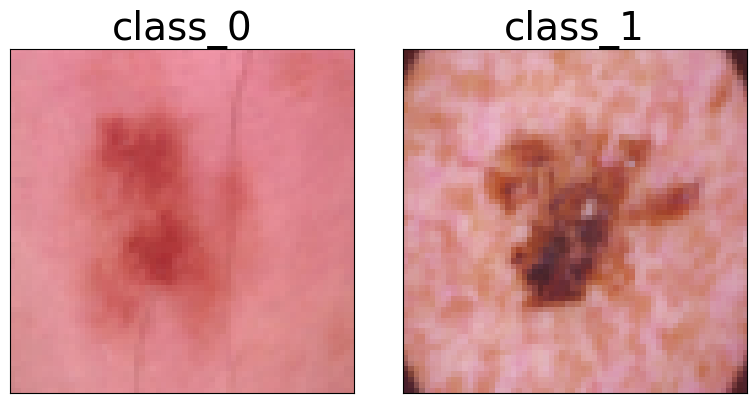

In [ ]:
inv_normalize = transforms.Normalize(
  mean= [-m/s for m, s in zip(mean, std)],
  std= [1/s for s in std]
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*4,1*4), subplot_kw={'facecolor': "#ebf5ff"})

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[i], fontsize=28)
  img = next(img for img,label in train_set if label == i)
  #ax.imshow(img.permute(1,2,0)) # for normalized channels
  ax.imshow(inv_normalize(img).permute(1,2,0)) # for unnormalized

fig.tight_layout()

In [ ]:
# batch size defines how many training or testing samples
# to use in a single iteration
batch_size = 50
# epochs define the number of iterations
epochs = 100
# num_classes define the number of the class
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")

Number of Classes: 2


In [ ]:
# Create dataloaders object.

train_dataloader = DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2)

val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)

Or we can display all images and its ground truth from a random batch.

In [ ]:
# We define a small function to determine the columns and rows needed
# for a given number of images.
def rows_cols(input):

    divisors = []

    # Realize a little operation with input
    # in order to determine divisors for input
    for i in range(1, input+1): # not divide by 0
        if input % i == 0:
            divisors.append(i)

    # divisors list size
    n = len(divisors)

    # If the size is odd, the element in the middle is the median value.
    if n % 2 != 0:
        median_index = (n - 1) // 2
        rows = divisors[median_index]
    # If the size is even, the two elements in the middle are equal
    else:
        median_index1 = n // 2 - 1
        rows = divisors[median_index1]

    cols = int(input/rows)
    return rows, cols


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


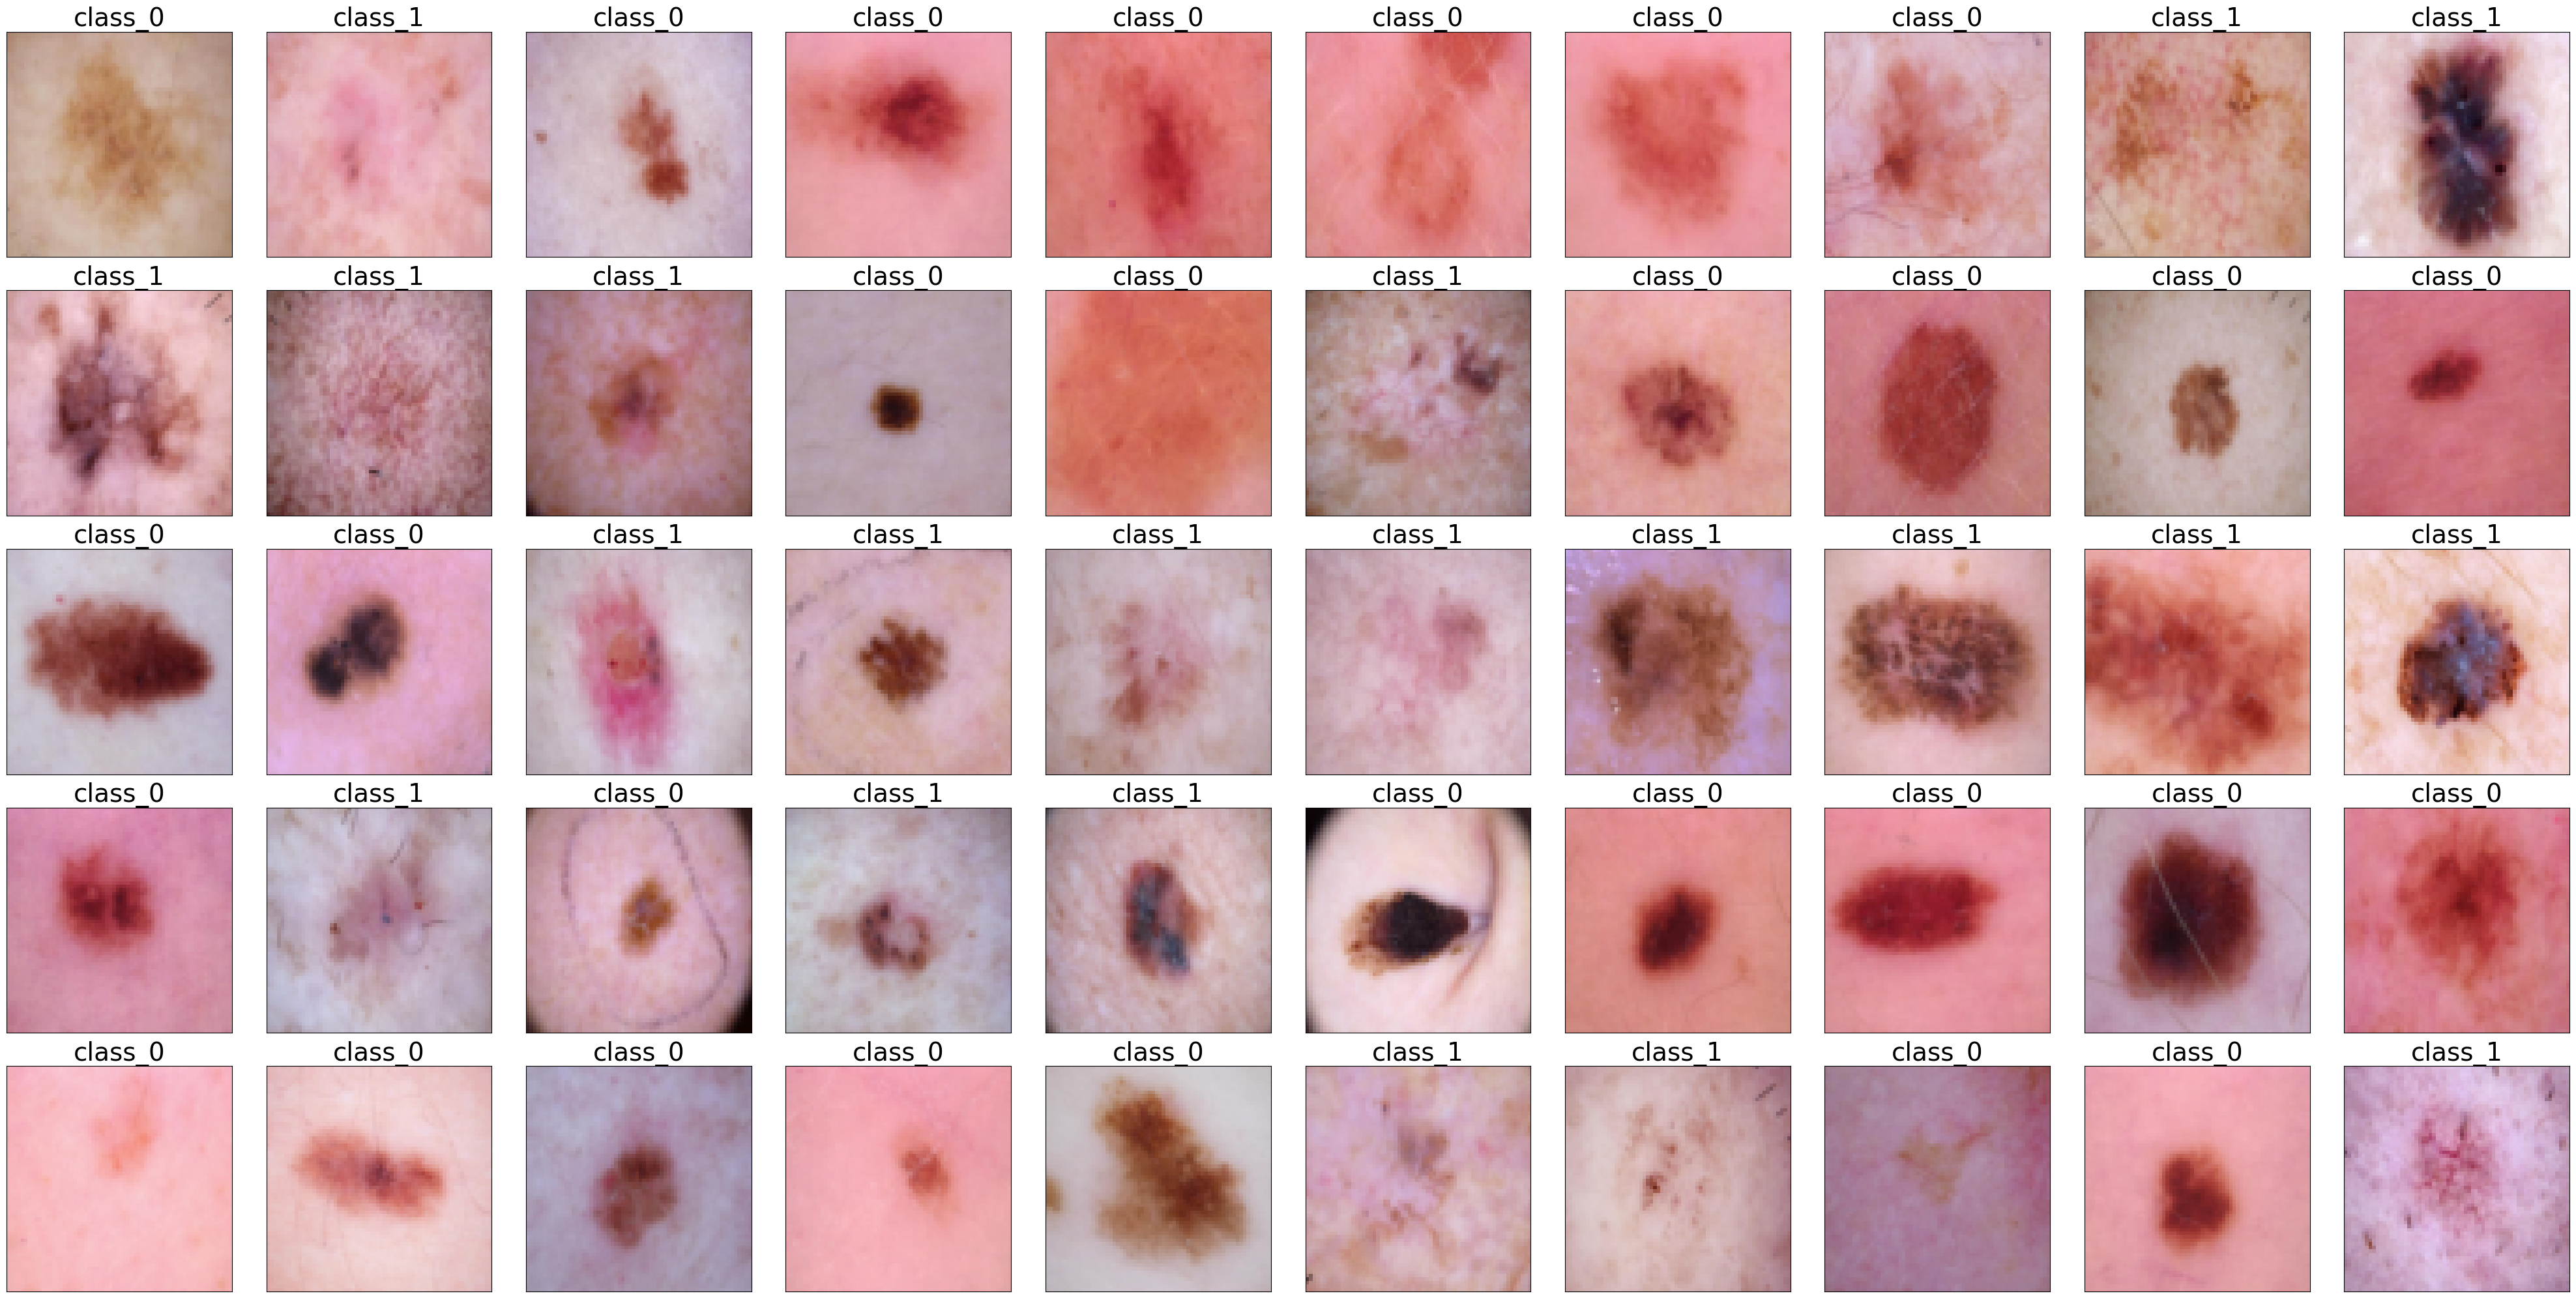

In [ ]:
import itertools
import random

nrows,ncols = rows_cols(batch_size)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4), subplot_kw={'facecolor': "#ebf5ff"})
rb_index = random.randint(0, len(train_dataloader))

# Obtener el batch correspondiente al índice aleatorio
imgs, labels = next(itertools.islice(train_dataloader, rb_index, rb_index+1))

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[labels[i]], fontsize=28)
  #ax.imshow(imgs[i].permute(1,2,0)) # for unnormalized
  ax.imshow(inv_normalize(imgs[i]).permute(1,2,0)) # for unnormalized

fig.tight_layout()


import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=1"


### 2. Define a Convolutional Neural Network


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Large Model
class CNN_Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(16384,128), #1024
            nn.ReLU(),
            nn.Linear(128, 64), #512
            nn.ReLU(),
            nn.Linear(64,2) #6
        )

    def forward(self, xb):
        return self.network(xb)



In this modified version:

- I added Batch Normalization layers (`nn.BatchNorm2d` for convolutional layers and `nn.BatchNorm1d` for fully connected layers) after each activation function to stabilize and accelerate training.
- Dropout layers (`nn.Dropout2d` for convolutional layers and `nn.Dropout` for fully connected layers) were introduced after each activation function to prevent overfitting.
- I adjusted the input size of the first fully connected layer (`nn.Linear`) based on the output size of the previous layer's `Flatten` operation.
- The dropout rate for fully connected layers was set to 0.5, which is a common value for dropout rates in practice.

Feel free to adjust the hyperparameters, such as dropout rates or batch normalization momentum, to further optimize the model's performance based on your specific dataset and training settings. Additionally, you may experiment with different optimizer configurations and learning rate schedules to find the best training setup for your model.

In [ ]:
class Improved_CNN_Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Add Batch Normalization
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Add Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),  # Add Dropout

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add Batch Normalization
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),  # Add Dropout

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Add Batch Normalization
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Add Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),  # Add Dropout

            nn.Flatten(),
            nn.Linear(16384, 128),  # Adjust input size based on the previous layer's output
            nn.BatchNorm1d(128),  # Add Batch Normalization for fully connected layers
            nn.ReLU(),
            nn.Dropout(0.5),  # Add Dropout
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),  # Add Batch Normalization for fully connected layers
            nn.ReLU(),
            nn.Dropout(0.5),  # Add Dropout
            nn.Linear(64, 2)  # Adjust output size
        )

    def forward(self, xb):
        return self.network(xb)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = Improved_CNN_Classification().to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

print(model)


Using cuda device
Improved_CNN_Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [ ]:
from torchsummary import summary

summary(model, (3,64,64)) # input = [3,64,64]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]         147,584
      BatchNorm2d-13          [-1, 128, 32, 32]             256
             ReLU-14          [-1, 128,

In [ ]:
!pip install -q torchviz

In [ ]:
from torchviz import make_dot

# Creamos un tensor de entrada
x = torch.randn(batch_size, 3, 64, 64, device=device)

# Obtenemos la salida de la red neuronal
y = model(x)

# Visualizamos el grafo de cálculo de la red neuronal
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render(filename='Improved_CNN', format='png')

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])

### 3. Define a Loss function and optimizer
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html). Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [ ]:

criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
# Define your optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.001 )
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 4. Train the network


In [ ]:
print (len(train_dataloader.dataset)) #number of images from dataset
print (len(train_dataloader)) # number of images/batch_size (or number of batches)

2700
54


En un training loop, se utiliza un conjunto de datos de entrenamiento. Este conjunto de datos está compuesto por ejemplos de entrada (por ejemplo, imágenes en un problema de clasificación de imágenes) y sus correspondientes etiquetas o salidas deseadas (por ejemplo, las etiquetas de clase asociadas a cada imagen). El propósito del training loop es iterar sobre este conjunto de datos para actualizar los pesos del modelo durante el entrenamiento.

El conjunto de datos de entrenamiento se utiliza para ajustar los parámetros del modelo, es decir, los pesos de las conexiones entre las neuronas de la red neuronal. Durante cada iteración del training loop, el modelo calcula las predicciones para un lote de ejemplos de entrada, compara esas predicciones con las etiquetas verdaderas utilizando una función de pérdida (o loss function), y luego ajusta los pesos del modelo para minimizar esta función de pérdida.

Las métricas que se utilizan para determinar un buen aprendizaje dependen del problema específico que estés abordando. Algunas métricas comunes incluyen:

1. **Precisión (Accuracy)**: Es la proporción de ejemplos clasificados correctamente por el modelo con respecto al total de ejemplos.
   
2. **Pérdida (Loss)**: Es una medida de qué tan bien está haciendo el modelo en sus predicciones. Las funciones de pérdida típicamente asignan un valor numérico a la diferencia entre las predicciones del modelo y las etiquetas verdaderas. El objetivo del entrenamiento es minimizar esta pérdida.

3. **Precisión por clase**: En problemas de clasificación con múltiples clases, puede ser útil examinar la precisión del modelo para cada clase individualmente.

4. **Tiempo de entrenamiento**: La cantidad de tiempo necesario para entrenar el modelo puede ser una métrica importante, especialmente en aplicaciones en tiempo real.

Estas métricas se utilizan para evaluar el rendimiento del modelo durante el entrenamiento y la validación, y para tomar decisiones sobre la arquitectura del modelo, los hiperparámetros y otros aspectos del proceso de entrenamiento.

In [ ]:
def train(dataloader, model, criterion, optimizer):
  running_loss, correct, current = 0, 0, 0
  size = len(dataloader.dataset) # number images from dataset
  loop = tqdm(train_dataloader) # progressive bar
  model.train()
  for batch, (X, y) in enumerate(loop):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    preds = model(X)
    loss = criterion(preds, y)

    # Backpropagation
    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()
    optimizer.step()        # Does the update

    # print statistics

    # 1. loss.item() contains the loss of entire mini-batch,
    # but divided by the batch size
    running_loss += loss.item() #

    current += len(X) # current image (last image in the batch)

    correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    training_loss = running_loss/(batch+1)

    training_accuracy = correct/current

    loop.set_description(f'[{epoch + 1}/{epochs} epochs, {current:>5d}/{len(train_dataloader.dataset):>5d} data]')

    loop.set_postfix(Training_Loss = training_loss, Accuracy = 100*correct/current)

  return training_loss, training_accuracy

In [ ]:
def val(dataloader, model, criterion):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  val_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      preds = model(X)
      val_loss += criterion(preds, y).item()
      correct += (preds.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg val loss: {val_loss:>8f} \n")

  return val_loss, correct

In [ ]:
loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []
for epoch in range(epochs):
  #print(f"Epoch {epoch+1}\n-------------------------------")
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_val,acc_val= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_val)
  accuracy_val_history.append(acc_val)
print("Done!. Finished Training")

  0%|          | 0/54 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[1/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.67it/s, Accuracy=61.9, Training_Loss=0.642]


Test Error: 
 Accuracy: 72.7%, Avg val loss: 0.528217 



[2/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.72it/s, Accuracy=69.8, Training_Loss=0.554]


Test Error: 
 Accuracy: 72.3%, Avg val loss: 0.520981 



[3/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.54it/s, Accuracy=72.7, Training_Loss=0.538]


Test Error: 
 Accuracy: 72.7%, Avg val loss: 0.501372 



[4/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.88it/s, Accuracy=73.7, Training_Loss=0.521]


Test Error: 
 Accuracy: 72.7%, Avg val loss: 0.493648 



[5/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.49it/s, Accuracy=74.8, Training_Loss=0.504]


Test Error: 
 Accuracy: 72.0%, Avg val loss: 0.508740 



[6/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.05it/s, Accuracy=74.3, Training_Loss=0.501]


Test Error: 
 Accuracy: 75.0%, Avg val loss: 0.504579 



[7/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.93it/s, Accuracy=74.1, Training_Loss=0.494]


Test Error: 
 Accuracy: 73.7%, Avg val loss: 0.491124 



[8/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.99it/s, Accuracy=74, Training_Loss=0.495]


Test Error: 
 Accuracy: 76.0%, Avg val loss: 0.482049 



[9/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.97it/s, Accuracy=74.9, Training_Loss=0.484]


Test Error: 
 Accuracy: 76.3%, Avg val loss: 0.483437 



[10/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.90it/s, Accuracy=76.3, Training_Loss=0.475]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.469951 



[11/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.86it/s, Accuracy=76.3, Training_Loss=0.472]


Test Error: 
 Accuracy: 75.7%, Avg val loss: 0.478236 



[12/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.96it/s, Accuracy=76.4, Training_Loss=0.473]


Test Error: 
 Accuracy: 73.0%, Avg val loss: 0.493914 



[13/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.85it/s, Accuracy=76.8, Training_Loss=0.471]


Test Error: 
 Accuracy: 75.3%, Avg val loss: 0.468833 



[14/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.90it/s, Accuracy=75.7, Training_Loss=0.481]


Test Error: 
 Accuracy: 75.3%, Avg val loss: 0.479158 



[15/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.99it/s, Accuracy=76.5, Training_Loss=0.461]


Test Error: 
 Accuracy: 72.3%, Avg val loss: 0.495885 



[16/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.87it/s, Accuracy=77, Training_Loss=0.46]


Test Error: 
 Accuracy: 77.0%, Avg val loss: 0.459980 



[17/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.85it/s, Accuracy=75.5, Training_Loss=0.466]


Test Error: 
 Accuracy: 78.3%, Avg val loss: 0.456755 



[18/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  7.03it/s, Accuracy=76.9, Training_Loss=0.453]


Test Error: 
 Accuracy: 75.3%, Avg val loss: 0.459468 



[19/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.84it/s, Accuracy=77, Training_Loss=0.455]


Test Error: 
 Accuracy: 75.3%, Avg val loss: 0.479442 



[20/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.82it/s, Accuracy=77.6, Training_Loss=0.449]


Test Error: 
 Accuracy: 74.7%, Avg val loss: 0.483575 



[21/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.86it/s, Accuracy=77.4, Training_Loss=0.45]


Test Error: 
 Accuracy: 76.7%, Avg val loss: 0.464032 



[22/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.90it/s, Accuracy=77.9, Training_Loss=0.456]


Test Error: 
 Accuracy: 75.7%, Avg val loss: 0.487596 



[23/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.74it/s, Accuracy=78.9, Training_Loss=0.442]


Test Error: 
 Accuracy: 76.7%, Avg val loss: 0.456450 



[24/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  7.00it/s, Accuracy=76.9, Training_Loss=0.451]


Test Error: 
 Accuracy: 76.0%, Avg val loss: 0.467342 



[25/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.15it/s, Accuracy=78, Training_Loss=0.442]


Test Error: 
 Accuracy: 77.7%, Avg val loss: 0.458458 



[26/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.77it/s, Accuracy=78.4, Training_Loss=0.447]


Test Error: 
 Accuracy: 76.3%, Avg val loss: 0.458281 



[27/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.39it/s, Accuracy=79.6, Training_Loss=0.431]


Test Error: 
 Accuracy: 76.0%, Avg val loss: 0.452691 



[28/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.83it/s, Accuracy=78.2, Training_Loss=0.441]


Test Error: 
 Accuracy: 77.0%, Avg val loss: 0.454457 



[29/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.88it/s, Accuracy=79.7, Training_Loss=0.431]


Test Error: 
 Accuracy: 76.3%, Avg val loss: 0.459287 



[30/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.95it/s, Accuracy=79.1, Training_Loss=0.429]


Test Error: 
 Accuracy: 76.7%, Avg val loss: 0.455102 



[31/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.92it/s, Accuracy=79.2, Training_Loss=0.423]


Test Error: 
 Accuracy: 77.0%, Avg val loss: 0.451790 



[32/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.76it/s, Accuracy=79.6, Training_Loss=0.418]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.439668 



[33/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.63it/s, Accuracy=79.7, Training_Loss=0.424]


Test Error: 
 Accuracy: 75.3%, Avg val loss: 0.459292 



[34/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.92it/s, Accuracy=79.8, Training_Loss=0.426]


Test Error: 
 Accuracy: 75.0%, Avg val loss: 0.462420 



[35/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.71it/s, Accuracy=79.8, Training_Loss=0.42]


Test Error: 
 Accuracy: 77.7%, Avg val loss: 0.468948 



[36/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.75it/s, Accuracy=80.4, Training_Loss=0.41]


Test Error: 
 Accuracy: 77.0%, Avg val loss: 0.435491 



[37/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.73it/s, Accuracy=80.5, Training_Loss=0.409]


Test Error: 
 Accuracy: 77.7%, Avg val loss: 0.445567 



[38/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.07it/s, Accuracy=79.7, Training_Loss=0.425]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.439262 



[39/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.78it/s, Accuracy=79.9, Training_Loss=0.416]


Test Error: 
 Accuracy: 77.0%, Avg val loss: 0.443284 



[40/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.62it/s, Accuracy=80.4, Training_Loss=0.408]


Test Error: 
 Accuracy: 77.3%, Avg val loss: 0.435895 



[41/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.57it/s, Accuracy=80.5, Training_Loss=0.414]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.444061 



[42/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.75it/s, Accuracy=80.7, Training_Loss=0.401]


Test Error: 
 Accuracy: 75.3%, Avg val loss: 0.473715 



[43/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.39it/s, Accuracy=80.6, Training_Loss=0.407]


Test Error: 
 Accuracy: 74.0%, Avg val loss: 0.462522 



[44/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.76it/s, Accuracy=81.3, Training_Loss=0.404]


Test Error: 
 Accuracy: 75.3%, Avg val loss: 0.470399 



[45/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.80it/s, Accuracy=81.3, Training_Loss=0.391]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.446623 



[46/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.33it/s, Accuracy=81, Training_Loss=0.396]


Test Error: 
 Accuracy: 75.7%, Avg val loss: 0.456932 



[47/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.82it/s, Accuracy=81, Training_Loss=0.403]


Test Error: 
 Accuracy: 78.3%, Avg val loss: 0.459879 



[48/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.73it/s, Accuracy=81.5, Training_Loss=0.395]


Test Error: 
 Accuracy: 76.7%, Avg val loss: 0.452975 



[49/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.95it/s, Accuracy=81.1, Training_Loss=0.388]


Test Error: 
 Accuracy: 77.3%, Avg val loss: 0.458218 



[50/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.91it/s, Accuracy=81.7, Training_Loss=0.39]


Test Error: 
 Accuracy: 75.0%, Avg val loss: 0.493635 



[51/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.75it/s, Accuracy=81.6, Training_Loss=0.391]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.447903 



[52/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.67it/s, Accuracy=81.9, Training_Loss=0.388]


Test Error: 
 Accuracy: 77.0%, Avg val loss: 0.440208 



[53/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.92it/s, Accuracy=82.4, Training_Loss=0.383]


Test Error: 
 Accuracy: 76.7%, Avg val loss: 0.448460 



[54/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.82it/s, Accuracy=81.8, Training_Loss=0.379]


Test Error: 
 Accuracy: 76.7%, Avg val loss: 0.463249 



[55/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.82it/s, Accuracy=82.1, Training_Loss=0.379]


Test Error: 
 Accuracy: 76.3%, Avg val loss: 0.476672 



[56/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.87it/s, Accuracy=82.4, Training_Loss=0.365]


Test Error: 
 Accuracy: 76.7%, Avg val loss: 0.472090 



[57/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.21it/s, Accuracy=82, Training_Loss=0.376]


Test Error: 
 Accuracy: 79.0%, Avg val loss: 0.436802 



[58/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.73it/s, Accuracy=82.5, Training_Loss=0.379]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.450946 



[59/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.67it/s, Accuracy=82.1, Training_Loss=0.374]


Test Error: 
 Accuracy: 77.7%, Avg val loss: 0.475565 



[60/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.59it/s, Accuracy=82.9, Training_Loss=0.368]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.458836 



[61/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.86it/s, Accuracy=83.4, Training_Loss=0.366]


Test Error: 
 Accuracy: 77.7%, Avg val loss: 0.490575 



[62/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.50it/s, Accuracy=83, Training_Loss=0.371]


Test Error: 
 Accuracy: 79.3%, Avg val loss: 0.462417 



[63/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.56it/s, Accuracy=82.8, Training_Loss=0.365]


Test Error: 
 Accuracy: 76.0%, Avg val loss: 0.492782 



[64/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.71it/s, Accuracy=83.6, Training_Loss=0.363]


Test Error: 
 Accuracy: 76.3%, Avg val loss: 0.524734 



[65/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.66it/s, Accuracy=83.3, Training_Loss=0.368]


Test Error: 
 Accuracy: 77.7%, Avg val loss: 0.475991 



[66/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.66it/s, Accuracy=83.9, Training_Loss=0.359]


Test Error: 
 Accuracy: 79.0%, Avg val loss: 0.462046 



[67/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.81it/s, Accuracy=84, Training_Loss=0.355]


Test Error: 
 Accuracy: 77.7%, Avg val loss: 0.480658 



[68/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.29it/s, Accuracy=84, Training_Loss=0.344]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.455940 



[69/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.81it/s, Accuracy=85.5, Training_Loss=0.336]


Test Error: 
 Accuracy: 79.3%, Avg val loss: 0.469036 



[70/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.77it/s, Accuracy=83.8, Training_Loss=0.347]


Test Error: 
 Accuracy: 80.3%, Avg val loss: 0.469639 



[71/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.90it/s, Accuracy=83.6, Training_Loss=0.351]


Test Error: 
 Accuracy: 79.0%, Avg val loss: 0.480038 



[72/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.92it/s, Accuracy=83.4, Training_Loss=0.353]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.469615 



[73/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.76it/s, Accuracy=84.1, Training_Loss=0.344]


Test Error: 
 Accuracy: 75.7%, Avg val loss: 0.504264 



[74/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.78it/s, Accuracy=84.8, Training_Loss=0.333]


Test Error: 
 Accuracy: 77.3%, Avg val loss: 0.476587 



[75/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.92it/s, Accuracy=84.4, Training_Loss=0.336]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.484182 



[76/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.79it/s, Accuracy=85.6, Training_Loss=0.332]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.497274 



[77/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.78it/s, Accuracy=85.9, Training_Loss=0.323]


Test Error: 
 Accuracy: 79.3%, Avg val loss: 0.489757 



[78/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.98it/s, Accuracy=84.6, Training_Loss=0.332]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.483432 



[79/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.06it/s, Accuracy=85.6, Training_Loss=0.33]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.467272 



[80/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.76it/s, Accuracy=85.5, Training_Loss=0.322]


Test Error: 
 Accuracy: 78.3%, Avg val loss: 0.483912 



[81/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.76it/s, Accuracy=85.3, Training_Loss=0.321]


Test Error: 
 Accuracy: 79.0%, Avg val loss: 0.478672 



[82/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.15it/s, Accuracy=86.1, Training_Loss=0.312]


Test Error: 
 Accuracy: 79.0%, Avg val loss: 0.471079 



[83/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.65it/s, Accuracy=85.4, Training_Loss=0.315]


Test Error: 
 Accuracy: 77.0%, Avg val loss: 0.479355 



[84/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.40it/s, Accuracy=86.2, Training_Loss=0.306]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.481745 



[85/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.85it/s, Accuracy=86.3, Training_Loss=0.315]


Test Error: 
 Accuracy: 81.0%, Avg val loss: 0.481032 



[86/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.77it/s, Accuracy=85.4, Training_Loss=0.315]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.469544 



[87/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.21it/s, Accuracy=86.5, Training_Loss=0.296]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.483417 



[88/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.96it/s, Accuracy=86.4, Training_Loss=0.304]


Test Error: 
 Accuracy: 77.7%, Avg val loss: 0.488286 



[89/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.77it/s, Accuracy=87, Training_Loss=0.297]


Test Error: 
 Accuracy: 77.0%, Avg val loss: 0.528706 



[90/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.20it/s, Accuracy=86.8, Training_Loss=0.288]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.510345 



[91/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.83it/s, Accuracy=86.7, Training_Loss=0.301]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.509331 



[92/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.66it/s, Accuracy=87.4, Training_Loss=0.289]


Test Error: 
 Accuracy: 78.7%, Avg val loss: 0.493398 



[93/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.78it/s, Accuracy=87, Training_Loss=0.295]


Test Error: 
 Accuracy: 76.7%, Avg val loss: 0.510612 



[94/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:08<00:00,  6.72it/s, Accuracy=86.9, Training_Loss=0.292]


Test Error: 
 Accuracy: 79.7%, Avg val loss: 0.488693 



[95/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.58it/s, Accuracy=88.9, Training_Loss=0.263]


Test Error: 
 Accuracy: 75.0%, Avg val loss: 0.503845 



[96/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.74it/s, Accuracy=87.3, Training_Loss=0.284]


Test Error: 
 Accuracy: 75.3%, Avg val loss: 0.536988 



[97/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.91it/s, Accuracy=87.3, Training_Loss=0.282]


Test Error: 
 Accuracy: 77.3%, Avg val loss: 0.522237 



[98/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.73it/s, Accuracy=87.8, Training_Loss=0.269]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.525354 



[99/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:09<00:00,  5.85it/s, Accuracy=89, Training_Loss=0.256]


Test Error: 
 Accuracy: 79.7%, Avg val loss: 0.496350 



[100/100 epochs,  2700/ 2700 data]: 100%|██████████| 54/54 [00:07<00:00,  6.95it/s, Accuracy=88.1, Training_Loss=0.268]


Test Error: 
 Accuracy: 78.0%, Avg val loss: 0.508197 

Done!. Finished Training


If your training process is oscillating and not improving accuracy, there could be several reasons for this issue. Here are some common ones and possible solutions:

1. **Learning rate too high or too low**: If the learning rate is too high, the optimization process may overshoot the optimal solution, causing oscillations. Conversely, if the learning rate is too low, the optimization process may get stuck in local minima. Try adjusting the learning rate. You can try reducing it gradually during training (learning rate scheduling) or using adaptive learning rate algorithms like Adam.

2. **Poor initialization**: The initial weights of the neural network could be poorly chosen, leading to oscillations. Try initializing the weights using different strategies, such as Xavier or He initialization.

3. **Overfitting**: If your model is too complex relative to the amount of training data, it may overfit, causing oscillations in performance. Regularization techniques like dropout or weight decay can help combat overfitting.

4. **Insufficient data augmentation**: If you're working with a small dataset, augmenting the data (e.g., by rotating, flipping, or scaling the images) can help the model generalize better and reduce oscillations.

5. **Model architecture**: The architecture of your neural network may not be suitable for the problem at hand. Experiment with different architectures, layer sizes, and activation functions to see if you can achieve better performance.

6. **Hyperparameter tuning**: Other hyperparameters such as batch size, number of layers, and optimizer choice could also affect the training process. Try experimenting with different values for these hyperparameters to find the best combination.

7. **Early stopping**: Implement early stopping based on validation performance to prevent overfitting and avoid wasting computational resources on training epochs that do not improve validation performance.

8. **Data imbalance**: If the classes in your dataset are imbalanced, the model may focus too much on the majority class and perform poorly on the minority class. Consider using techniques such as class weights or oversampling/undersampling to address this issue.

By systematically diagnosing and addressing these potential issues, you should be able to stabilize the training process and improve the accuracy of your model.

Thank you for providing the example. Based on the information you provided, it seems that the training accuracy is increasing steadily, indicating that the model is learning well from the training data. However, the test accuracy is not improving significantly, which suggests that the model might be overfitting to the training data.

Here are some suggestions to address this issue:

1. **Regularization**: Apply regularization techniques such as L2 regularization or dropout to prevent overfitting. Regularization penalizes large weights in the model, making it more robust to noise in the training data.

2. **Data Augmentation**: Increase the diversity of the training data by applying data augmentation techniques such as random rotations, translations, and flips. This can help the model generalize better to unseen data.

3. **Model Complexity**: Simplify the model architecture by reducing the number of parameters or layers. A simpler model may generalize better to the test data.

4. **Learning Rate Schedule**: Experiment with learning rate schedules such as reducing the learning rate over time (learning rate decay) to help the model converge to a better solution.

5. **Early Stopping**: Implement early stopping based on the validation performance to prevent the model from overfitting to the training data.

6. **Hyperparameter Tuning**: Fine-tune the hyperparameters of the model, such as the learning rate, batch size, and optimizer, to achieve better performance on the test data.

By applying these techniques and carefully monitoring the training and test performance, you should be able to improve the overall accuracy of your model.

If the training accuracy and training loss are satisfactory, but the test accuracy and test loss are poor, it indicates that your model is overfitting to the training data. Overfitting occurs when the model learns to memorize the training data rather than generalize to unseen data.

Here are some common reasons why overfitting might occur and potential solutions:

1. **Model Complexity**: Your model might be too complex relative to the amount of training data. As a result, it learns to fit the noise in the training data rather than capturing the underlying patterns. You can try simplifying your model architecture by reducing the number of parameters or layers.

2. **Insufficient Data**: If you have a small dataset, your model may not have enough examples to learn the underlying patterns effectively. Consider collecting more data if possible or using data augmentation techniques to artificially increase the size of your dataset.

3. **Regularization**: Regularization techniques such as dropout, L2 regularization, or early stopping can help prevent overfitting. Dropout randomly drops some neurons during training, which can prevent the model from relying too much on any single feature. L2 regularization penalizes large weights in the model, discouraging overfitting.

4. **Data Quality**: Poor quality or noisy data can lead to overfitting. Make sure your data is clean and free of errors. You can also consider preprocessing your data to remove outliers or irrelevant features.

5. **Validation Set**: Ensure that you're using a separate validation set to monitor the model's performance during training. Use the validation set to tune hyperparameters and detect overfitting early.

6. **Early Stopping**: Implement early stopping based on the validation performance to prevent the model from overfitting. Stop training when the validation loss starts to increase, indicating that the model is beginning to overfit.

7. **Ensemble Methods**: Instead of relying on a single model, you can use ensemble methods to combine the predictions of multiple models. Ensemble methods often generalize better than individual models and can reduce overfitting.

By addressing these potential causes of overfitting and experimenting with different techniques, you should be able to improve the generalization performance of your model on the test set. Remember to monitor both the training and validation performance closely to ensure that your model is learning effectively without overfitting to the training data.

In [ ]:
fig, ax = plt.subplots()

ax.set_title('Training and Validation Plots')
ax.plot(range(epochs), loss_train_history, label="Loss Train")
ax.plot(range(epochs), accuracy_train_history, label="Accuracy Train")
ax.plot(range(epochs), loss_test_history, label="Loss Validation")
ax.plot(range(epochs), accuracy_test_history, label="Accuracy Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

NameError: name 'plt' is not defined